# Quantized inverse dynamic for  Go -Explore

In [5]:
import gym_continuous_maze
import numpy as np
from stable_baselines3 import SAC
from toolbox.maze_grid import cumulative_cells

from lge.inverse_dynamic_go_explore import GoExploreInverseModel

go_explore = GoExploreInverseModel(SAC, "ContinuousMaze-v0", traj_step=3, density_pow=-2.0, distance_threshold=1.0, verbose=1)
go_explore.explore(20_000)

Creating environment from the given name 'ContinuousMaze-v0'
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 82.8     |
|    ep_rew_mean     | -75      |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1099     |
|    time_elapsed    | 0        |
|    total_timesteps | 331      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 82.8     |
|    ep_rew_mean     | -75      |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1126     |
|    time_elapsed    | 0        |
|    total_timesteps | 662      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 71.2     |
|    ep_rew_mean     | -60.6    |
|    success_rate    | 0.417    |
| ti

Plot an exploration measure.

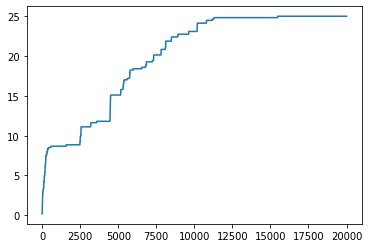

In [6]:
import matplotlib.pyplot as plt

archive = go_explore.archive
observations = archive.observations["observation"][: archive.pos]
counts = cumulative_cells(observations)
plt.plot(counts / (24 * 24) * 100)

Sample goals and trajectories. Draw them and store the image into `goals_and_traj.bmp`.

In [7]:
go_explore.archive.recompute_embeddings()

In [8]:
from toolbox.render_maze import render_and_save

traj = [go_explore.archive.sample_trajectory(step=3, density_pow=-2.0)[0] for _ in range(2)]
goals = [go_explore.archive.sample_trajectory(step=3, density_pow=-2.0)[0][-1] for _ in range(1000)]

env = go_explore.model.env.envs[0]
render_and_save(
    all_pos=env.all_pos,
    walls=env.walls,
    filename="goals_and_traj.bmp",
    trajectories=traj,
    goals=goals,
)

Render the latent space and the observation space to see the cells.

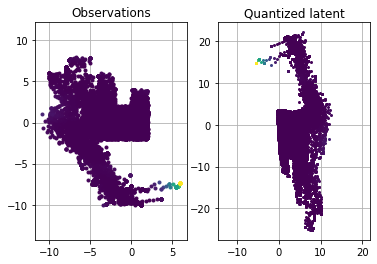

In [15]:
import matplotlib.pyplot as plt
import torch
from lge.utils import multinomial, estimate_density


cmap = plt.get_cmap()
observations = go_explore.archive.next_observations["observation"][:20000]
embeddings = go_explore.archive.encode(observations).detach().cpu().numpy()

embeddings = embeddings.reshape(20000, -1)
density = go_explore.archive.density[:20000]

weights = density**-2.0
weights = (weights - weights.min()) / (weights.max() - weights.min())

fig, axs = plt.subplots(1, 2)
# Observations
axs[0].grid()
axs[0].set_title("Observations")
axs[0].axis("equal")
for observation, weight in zip(observations, weights):
    axs[0].plot(*observation.T, "o", markersize=3, c=cmap(weight))

# Quantized latent
axs[1].grid()
axs[1].set_title("Quantized latent")
axs[1].axis("equal")
for embedding, weight in zip(embeddings, weights):
    axs[1].plot(*embedding.T, "o", markersize=2, c=cmap(weight))

# for _ in range(100):
#     goal_id = multinomial(go_explore.archive.to_torch(weights))
#     axs[0].plot(*observations[goal_id].T, "o", markersize=10, c="green")

Test wether the inverse model is accurate.

In [ ]:
# Sample one transition
sample = go_explore.archive.sample(1)
observations = sample.observations["observation"]
next_observations = sample.next_observations["observation"]
actions = sample.actions

# Predict the action
go_explore.inverse_model.eval()
pred_actions = go_explore.inverse_model(observations, next_observations)

# See the result
print("observation\t\t", observations)
print("next observation\t", next_observations)
print("true action\t\t", actions)
print("predicted action\t", pred_actions)

observation		 tensor([[-5.9263,  1.3379]])
next observation	 tensor([[-5.9263,  1.3379]])
true action		 tensor([[-0.7040, -0.8164]])
predicted action	 tensor([[-0.3154, -0.0638]], grad_fn=<AddmmBackward0>)
